# Image Classification using ImageNette + depth

> Image Classification using ImageNette + depth


- skip_showdoc: true
- skip_exec: true

## Data Preprocessing

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets, utils
from torch.utils.data import DataLoader
import torchvision.transforms.functional as TF

from tqdm import tqdm 
import matplotlib.pyplot as plt
import timm
import numpy as np
from datetime import datetime

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
#model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
#model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

midas = torch.hub.load("intel-isl/MiDaS", model_type)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

Using cache found in /home/ben/.cache/torch/hub/intel-isl_MiDaS_master


Loading weights:  None


Using cache found in /home/ben/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master
Using cache found in /home/ben/.cache/torch/hub/intel-isl_MiDaS_master


In [ ]:
class ComputeFFT(object):
    def __init__(self):
        super().__init__()
    
    def __call__(self, image):
        # Convert the color image to grayscale
        grayscale_image = TF.rgb_to_grayscale(image).squeeze()
        
        # Convert the grayscale image to tensor and apply FFT
        fft_result = torch.fft.fft2(grayscale_image)
        
        # Compute magnitude spectrum
        magnitude_spectrum = torch.log(torch.abs(fft_result) + 1)
        
        # Compute phase spectrum
        phase_spectrum = torch.angle(fft_result)
        
        combined_image = torch.cat((image, magnitude_spectrum.unsqueeze(0), phase_spectrum.unsqueeze(0)), dim=0)

        return combined_image

    def __repr__(self):
        return self.__class__.__name__ + '()'

In [ ]:
class ComputeDepth(object):
    def __init__(self, model, transform, device = "cuda"):
        super().__init__()
        self.device = device
        self.model = model
        self.model.to(self.device)
        self.model.eval()
        self.transform = transform
    
    def __call__(self, image):
        input_image = image.to('cpu').squeeze().numpy().transpose(1, 2, 0)
        # input_image = np.array(image)
        input_batch = transform(input_image).to(self.device)
        
        with torch.no_grad():
            prediction = self.model(input_batch)
            
            prediction = torch.nn.functional.interpolate(
                prediction.unsqueeze(1),
                size=input_image.shape[:2],
                mode="bicubic",
                align_corners=False,
            ).squeeze(0)
            prediction = prediction.to('cpu')

        prediction_mean = torch.mean(prediction)
        prediction_std = torch.std(prediction)
        
        # Calculate the scaling factors for normalization
        scale_factor = 0.225 / prediction_std
        bias = 0.45 - prediction_mean * scale_factor
        
        # Normalize the tensor to the desired mean and standard deviation
        prediction = prediction * scale_factor + bias
        
        combined_image = torch.cat((image, prediction), dim=0)

        return combined_image

    def __repr__(self):
        return self.__class__.__name__ + '()'

In [ ]:
# Define the transformations to apply to the images
# additional_transforms = transforms.Compose([
#     transforms.RandomResizedCrop(224),            # Random resized crop
#     transforms.RandomHorizontalFlip(),            # Random horizontal flip
#     transforms.RandomRotation(10),                # Random rotation by 10 degrees
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color jitter
#     transforms.RandomErasing(),                   # Random erasing
# ])
transform_default = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((150, 150)),
    # ComputeFFT(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize with ImageNet mean and std
    ComputeDepth(midas, transform, device = 'cpu'),
])

In [ ]:
transform_default

Compose(
    ToTensor()
    Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=True)
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ComputeDepth()
)

In [ ]:
# Download and load the Imagenette dataset
train_dataset = datasets.Imagenette(root='Data',
                                    split='train',
                                    # download=True,
                                    transform=transform_default,
                                    )


# Download and load the Imagenette dataset
test_dataset = datasets.Imagenette(root='Data',
                                  split='val',
                                  # download=True,
                                  transform=transform_default,
                                 )

In [ ]:
train_dataset.__dict__.keys()

dict_keys(['root', 'transform', 'target_transform', 'transforms', '_split', '_size', '_url', '_md5', '_size_root', '_image_root', 'wnids', 'wnid_to_idx', 'classes', 'class_to_idx', '_samples'])

In [ ]:
train_dataset.classes

[('tench', 'Tinca tinca'),
 ('English springer', 'English springer spaniel'),
 ('cassette player',),
 ('chain saw', 'chainsaw'),
 ('church', 'church building'),
 ('French horn', 'horn'),
 ('garbage truck', 'dustcart'),
 ('gas pump', 'gasoline pump', 'petrol pump', 'island dispenser'),
 ('golf ball',),
 ('parachute', 'chute')]

In [ ]:
len(train_dataset), len(test_dataset)

(9470, 3925)

In [ ]:
images, labels = train_dataset[10]
images.shape

torch.Size([4, 150, 150])

In [ ]:

image_np = images[:3].numpy().transpose((1, 2, 0))
image_np.shape

(150, 150, 3)

In [ ]:
# Define a function to display images
def show_image(dataset):
    # Access an image and its label from the dataset
    image, label = dataset
    
    # Convert the image tensor to a NumPy array
    image_np = image[:3].numpy().transpose((1, 2, 0))

    # Display the image using Matplotlib
    plt.imshow(image_np.clip(0,1))
    plt.axis('off')
    plt.title(f' {train_dataset.classes[label][0]}')
    plt.show()
    
   
# Define a function to display images
def show_images(images, labels, **kwargs):
    nrows = int(np.ceil(np.sqrt(len(images))))
    ncols = int(np.ceil(len(images)/nrows))
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 12),  **kwargs)
    # Adjust the spacing between subplots
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    for ax, image, label in zip(axes.flat, images, labels):
        # Convert image to numpy array and adjust pixel values
        img_np = image[:3].numpy().transpose((1, 2, 0))
        
        # Display image
        ax.imshow(img_np.clip(0,1))
        ax.axis('off')
        ax.set_title(f' {train_dataset.classes[label][0]}')
    for ax in axes.flat[len(images):]:
        ax.axis('off')
        
    plt.show()

# Define a function to display images
def show_depth(images, labels, **kwargs):
    nrows = int(np.ceil(np.sqrt(len(images))))
    ncols = int(np.ceil(len(images)/nrows))
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 12),  **kwargs)
    # Adjust the spacing between subplots
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    for ax, image, label in zip(axes.flat, images, labels):
        # Convert image to numpy array and adjust pixel values
        img_np = image[3].numpy()
        
        # Display image
        ax.imshow(img_np)
        ax.axis('off')
        ax.set_title(f' {train_dataset.classes[label][0]}')
    for ax in axes.flat[len(images):]:
        ax.axis('off')
        
    plt.show()

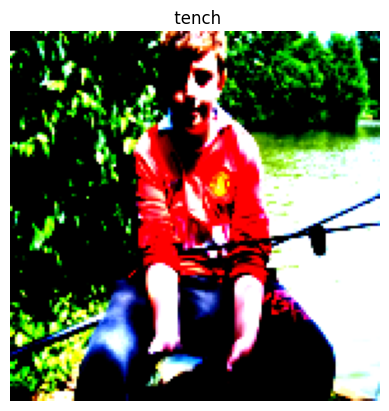

In [ ]:
show_image(train_dataset[2])

In [ ]:
def loaders(batch_size):

    train_loader = DataLoader(train_dataset,
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=8)
    test_loader = DataLoader(test_dataset,
                             batch_size=batch_size,
                             shuffle=False, 
                             num_workers=8)
    
    dataloaders = {'train': train_loader, 'val': test_loader}
    dataset_sizes = {'train': len(train_dataset), 'val': len(test_dataset) }
    return train_loader, test_loader, dataloaders, dataset_sizes

In [ ]:
batch_size = 32
train_loader, test_loader, dataloaders, dataset_sizes = loaders(batch_size)

In [ ]:
# Get a batch of images and labels from the data loader
examples = iter(test_loader)
images, labels = next(examples)
# ############## TENSORBOARD ########################
# img_grid = utils.make_grid(images)

# writer.add_image('Imagenette', img_grid)
# writer.flush()
# #sys.exit()
# ###################################################

In [ ]:
len(images)

In [ ]:
show_images(images, labels)

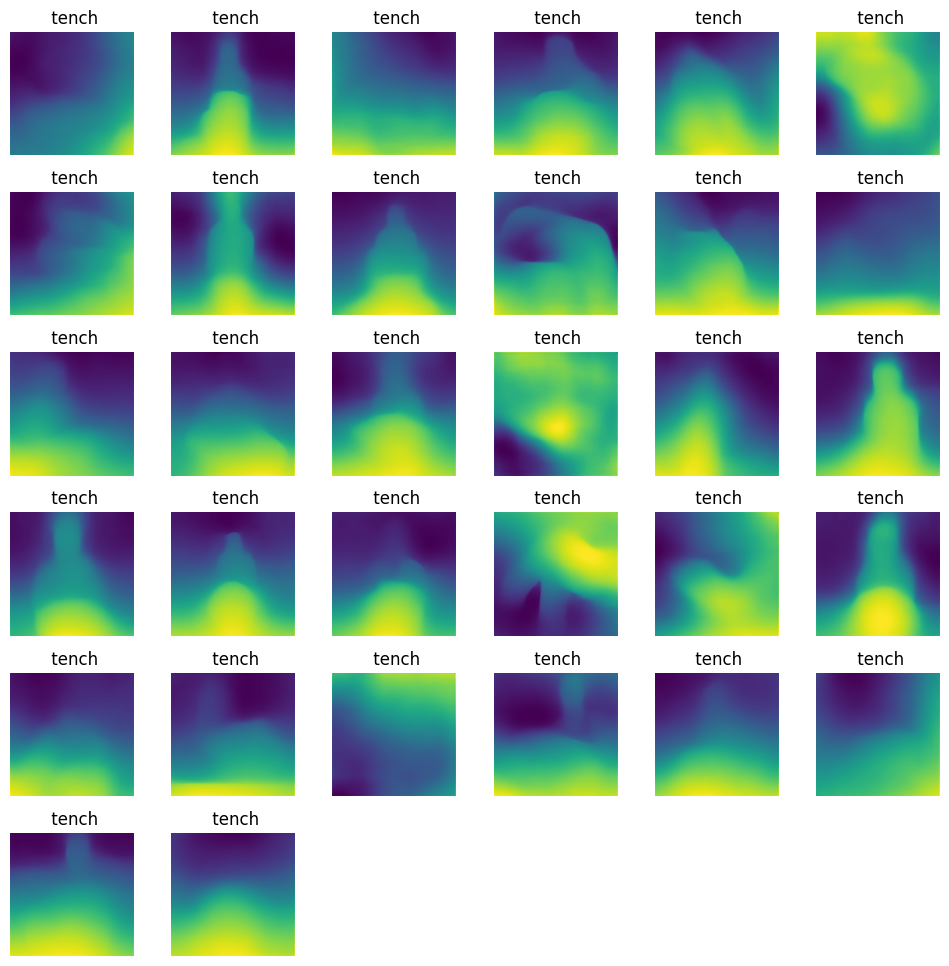

In [ ]:
show_depth(images, labels)

In [ ]:
images[1][1].shape

torch.Size([150, 150])

In [ ]:
images[1][3].max()

tensor(0.9077)

In [ ]:
images[1][2].max()

tensor(2.6400)

## Model Training

In [ ]:
timm.list_models('resnet*')[:5]

['resnet10t', 'resnet14t', 'resnet18', 'resnet18d', 'resnet26']

In [ ]:
def create_custom_model(model_name: str,
                        pretrained: bool = False,
                        input_channels:int = 3,
                        **kwargs):
    model = timm.create_model(model_name,
                              pretrained=pretrained,
                              **kwargs)


    model.conv1 = nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3, bias=False) 

    return model


In [ ]:
model = create_custom_model('resnet18',
                            pretrained=True,
                            input_channels = 4,
                            num_classes=10)

In [ ]:
def train_model(model, criterion, 
                optimizer, scheduler, 
                train_loader, epoch,
                n_total_steps, record = 10):
    running_loss = 0.0
    running_correct = 0
    model.train()
    for i, (images, labels) in enumerate(tqdm(train_loader)):  
        
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        running_correct += (predicted == labels).sum().item()
        if (i+1) % record == 0:
            ############## TENSORBOARD ########################
            writer.add_scalar('training loss', running_loss / record, epoch * n_total_steps + i)
            running_accuracy = running_correct / record / len(images)
            writer.add_scalar('training accuracy', running_accuracy, epoch * n_total_steps + i)
            running_correct = 0
            running_loss = 0.0
            writer.flush()
            ###################################################
    scheduler.step()
    

def eval_model(model, criterion, 
               optimizer, scheduler, 
               test_loader, epoch,
               n_total_steps, batch_size):
    running_loss = 0.0
    running_correct = 0
    running_accuracy = 0
    
    model.eval()
    len_batch = 0
    for i, (images, labels) in enumerate(tqdm(test_loader)):  
        images = images.to(device)
        labels = labels.to(device)
        len_batch = len(images)
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        running_correct += (predicted == labels).sum().item()
        
    ############## TENSORBOARD ########################
    writer.add_scalar('val loss',
                      running_loss / len(test_loader),
                      (epoch+1) * n_total_steps)
    running_accuracy = running_correct / len(test_loader) / batch_size
    writer.add_scalar('val accuracy',
                      running_accuracy,
                      (epoch+1) * n_total_steps)

    writer.flush()
    ###################################################

In [ ]:
def build_model(model, criterion, optimizer,
                scheduler, num_epochs=5, batch_size = 32, record = 10):
    
    train_loader, test_loader, _, _ = loaders(batch_size)

    model = model.to(device)

    n_total_steps = len(train_loader)
    for epoch in range(num_epochs):
        train_model(model, criterion,
                    optimizer, scheduler,
                    train_loader, epoch,
                    n_total_steps, record = 10)

        eval_model(model, criterion, 
                   optimizer, scheduler, 
                   test_loader, epoch, 
                   n_total_steps, batch_size)

    return model

## default setup

In [ ]:
# model = timm.create_model('resnet18',
#                           pretrained=True,
#                           num_classes=10)


In [ ]:
# learning_rate = 0.1
# num_epochs = 5
# batch_size = 64
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
# step_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


In [ ]:
# ############## TENSORBOARD ########################
# import sys
# from torch.utils.tensorboard import SummaryWriter
# # default `log_dir` is "runs" - we'll be more specific here
# formatted_time =  datetime.now().strftime("%Y-%m-%d_%H:%M:%S")

# writer = SummaryWriter(log_dir = f'runs/transforms everything {formatted_time}')

# writer.add_text('learning_rate', f'{learning_rate}')
# writer.add_text('epochs', f'{num_epochs}')
# writer.add_text('batch_size', f'{batch_size}')
# writer.add_text('criterion', f'{str(criterion)}')
# writer.add_text('optimizer', f'{str(optimizer)}')

# writer.add_graph(model, images)
# writer.flush()
# ###################################################

In [ ]:
# model = build_model(model = model,
#                     criterion = criterion,
#                     optimizer = optimizer,
#                     scheduler = step_lr_scheduler,
#                     num_epochs = num_epochs,
#                     batch_size = batch_size,
#                     record = 20)

In [ ]:
# del model
# torch.cuda.empty_cache()

In [ ]:
# ############## TENSORBOARD ########################
# writer.close()
# ###################################################

## Test Loop

In [ ]:
learning_rate = 0.1
num_epochs = 6
batch_size = 64
criterion = nn.CrossEntropyLoss()

In [ ]:
for a in range(1):
    model = create_custom_model('resnet34',
                                pretrained=True,
                                input_channels = 5,
                                num_classes=10)
    optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
    step_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)
    
    ######################## TENSORBOARD ########################
    import sys
    from torch.utils.tensorboard import SummaryWriter
    # default `log_dir` is "runs" - we'll be more specific here
    formatted_time =  datetime.now().strftime("%H:%M:%S")
    
    writer = SummaryWriter(log_dir = f'runs/add FFT {num_epochs} {formatted_time}')
    print(f'runs/add FFT {formatted_time}')
    
    writer.add_text('learning_rate', f'{learning_rate}')
    writer.add_text('epochs', f'{num_epochs}')
    writer.add_text('batch_size', f'{batch_size}')
    writer.add_text('criterion', f'{str(criterion)}')
    writer.add_text('optimizer', f'{str(optimizer)}')
    
    # writer.add_graph(model, images)
    writer.flush()
    ###################################################


    model = build_model(model = model,
                        criterion = criterion,
                        optimizer = optimizer,
                        scheduler = step_lr_scheduler,
                        num_epochs = num_epochs,
                        batch_size = batch_size,
                        record = 20)
    del model
    torch.cuda.empty_cache()
    
    ######################## TENSORBOARD ########################
    writer.close()
    ###################################################


runs/add FFT 18:45:33


  0%|                                                                                           | 0/148 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__>
Traceback (most recent call last):
  File "/home/ben/mambaforge/envs/pfast/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/ben/mambaforge/envs/pfast/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1443, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/home/ben/mambaforge/envs/pfast/lib/python3.12/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ben/mambaforge/envs/pfast/lib/python3.12/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ben/mambaforge/envs/pfast/lib/python3.12/multiprocessing/

RuntimeError: Given groups=1, weight of size [64, 5, 7, 7], expected input[64, 4, 150, 150] to have 5 channels, but got 4 channels instead